In [10]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.nn as nn
import torch
from torch_geometric.data import Data
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from tigramite.toymodels import structural_causal_processes


# Underlying SCM

* Taken from https://medium.com/causality-in-data-science/hands-on-causal-effect-estimation-with-python-aac40ca2cae0

In [11]:
# {
# 0: x_1 [], 
# 1: x_2 [((0, 0), coeff, lin_f), ((5, 0), coeff, lin_f)], 
# 2: M   [((1, 0), coeff, lin_f), ((5, 0), coeff, lin_f)],
# 3: Y   [((1, 0), coeff, lin_f), ((2, 0), coeff, lin_f), ((6, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
# 4: Z_1 [((5, 0), coeff, lin_f), ((7, 0), coeff, lin_f)], 
# 5: Z_2 [], 
# 6: Z_3 [],
# 7: [],
# }

# GNN with intervention == 0

In [12]:

def lin_f(x): return x

T = 1000

#  Generate the data
coeff = 0.5
intervention2 = 0.*np.ones(T)

links_coeffs = {
    0: [],
    1: [((0, 0), coeff, lin_f), ((5, 0), coeff, lin_f)],
    2: [((1, 0), coeff, lin_f), ((5, 0), coeff, lin_f)],
    3: [((1, 0), coeff, lin_f), ((2, 0), coeff, lin_f), ((6, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
    4: [((5, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
    5: [],
    6: [],
    7: [],
}
data_array, nonstat = structural_causal_processes.structural_causal_process(links_coeffs, T=T, noises=None, seed=7,
                                            intervention={0:intervention2, 1:intervention2}, 
                                            intervention_type='hard',)
data_array = data_array[:, [0, 1, 2, 3, 4, 5, 6]]  # Remove unobserved confounder (variable 7)

# Prepare the data for GNN input
# Create edge_index based on the causal relationships
edges = []
for target, sources in links_coeffs.items():
    if target == 7:  # Skip the unobserved confounder
        continue
    for source_info in sources:
        source = source_info[0][0]
        if source == 7:
            continue  # Skip edges from the unobserved confounder
        edges.append((source, target))
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Create dataset
dataset = []
for t in range(T):
    x = torch.tensor(data_array[t, :], dtype=torch.float).unsqueeze(1)  # Node features
    y = torch.tensor(data_array[t, 3], dtype=torch.float)  # Target variable at index 3
    graph_data = Data(x=x, edge_index=edge_index, y=y)
    dataset.append(graph_data)

# Split dataset
train_dataset = dataset[:800]
test_dataset = dataset[800:]

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the GNN architecture
class GNNModel(nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 16)
        self.lin = nn.Linear(16, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Extract embeddings of node 3 in each graph
        num_nodes_per_graph = 7
        x_node3 = x[torch.arange(3, x.size(0), num_nodes_per_graph)]

        out = self.lin(x_node3).squeeze()
        return out

#  Train the GNN on the data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = F.mse_loss(out, data.y.to(device))
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# Training loop
num_epochs = 600
for epoch in range(1, num_epochs + 1):
    loss = train()
    test_loss = test(test_loader)
    print(f'Epoch: {epoch}, Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}')




/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 1, Train Loss: 1.4472, Test Loss: 1.3623
Epoch: 2, Train Loss: 1.2073, Test Loss: 1.3660
Epoch: 3, Train Loss: 1.1823, Test Loss: 1.3590
Epoch: 4, Train Loss: 1.2093, Test Loss: 1.3649
Epoch: 5, Train Loss: 1.1854, Test Loss: 1.3549
Epoch: 6, Train Loss: 1.1910, Test Loss: 1.3639
Epoch: 7, Train Loss: 1.1859, Test Loss: 1.3703
Epoch: 8, Train Loss: 1.1821, Test Loss: 1.3575
Epoch: 9, Train Loss: 1.1879, Test Loss: 1.3562
Epoch: 10, Train Loss: 1.1795, Test Loss: 1.3561
Epoch: 11, Train Loss: 1.1750, Test Loss: 1.3578
Epoch: 12, Train Loss: 1.1780, Test Loss: 1.3676
Epoch: 13, Train Loss: 1.1772, Test Loss: 1.3651
Epoch: 14, Train Loss: 1.1732, Test Loss: 1.3689
Epoch: 15, Train Loss: 1.1805, Test Loss: 1.3592
Epoch: 16, Train Loss: 1.1801, Test Loss: 1.3587
Epoch: 17, Train Loss: 1.1873, Test Loss: 1.3683
Epoch: 18, Train Loss: 1.1841, Test Loss: 1.3588
Epoch: 19, Train Loss: 1.1911, Test Loss: 1.3522
Epoch: 20, Train Loss: 1.1863, Test Loss: 1.3782
Epoch: 21, Train Loss: 1.1729

Test MSE: 1.3205
Test SMAPE: 121.0159


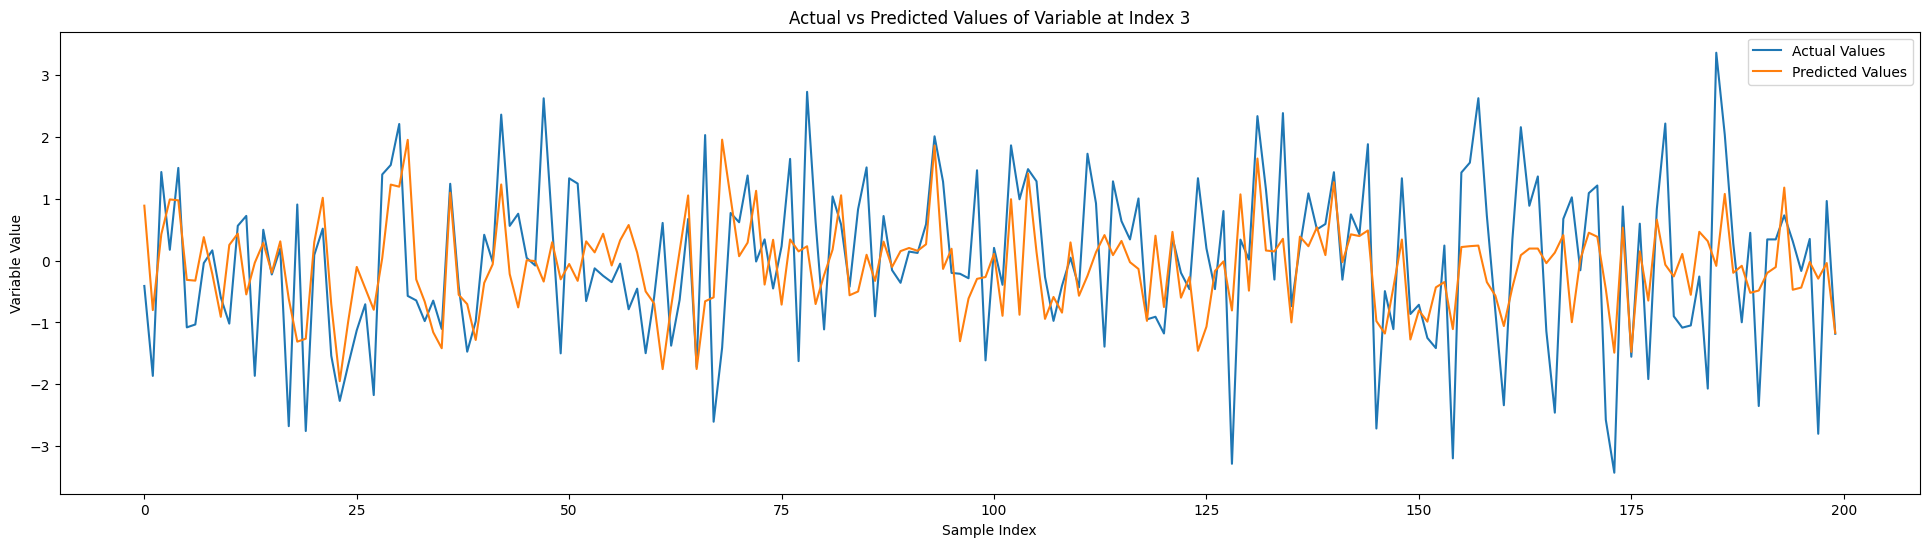

In [13]:
# Forecast using the test dataset
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        predictions.append(out.cpu())
        actuals.append(data.y.cpu())

# Concatenate all predictions and actual values
predictions = torch.cat(predictions, dim=0)
actuals = torch.cat(actuals, dim=0)

# Calculate Mean Squared Error on the test set
mse = mean_squared_error(actuals.numpy(), predictions.numpy())
print(f'Test MSE: {mse:.4f}')

def smape(predictions, actuals):
    return 100 * torch.mean(2 * torch.abs(predictions - actuals) / (torch.abs(predictions) + torch.abs(actuals)))

smape_ = smape(predictions, actuals)
print(f'Test SMAPE: {smape_:.4f}')

# plot the predictions vs actual values


plt.figure(figsize=(24, 6))
plt.plot(actuals.numpy(), label='Actual Values')
plt.plot(predictions.numpy(), label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Variable Value')
plt.title('Actual vs Predicted Values of Variable at Index 3')
plt.legend()
plt.show()

Training MSE: 1.0487


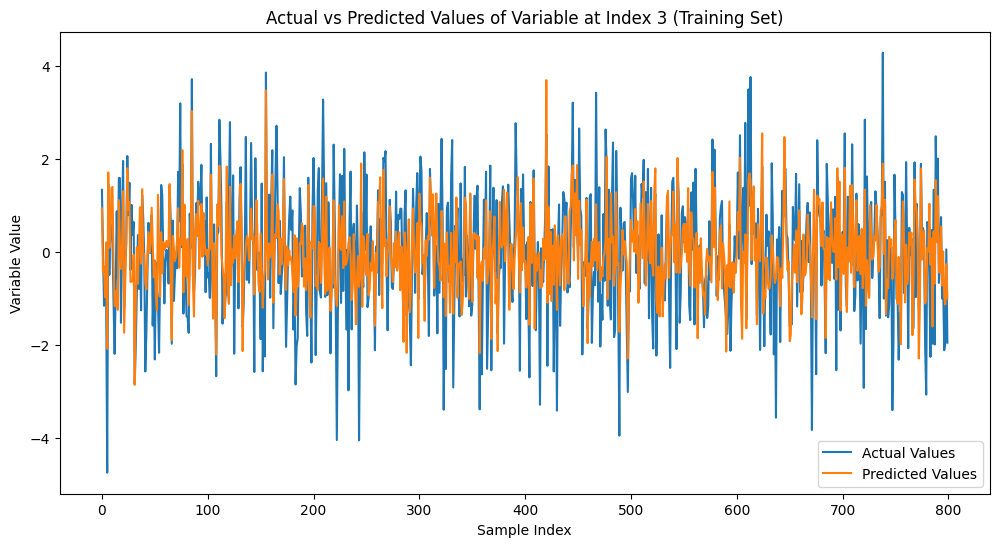

In [14]:
# Forecast using the training dataset
predictions_train = []
actuals_train = []
with torch.no_grad():
    for data in train_loader:
        data = data.to(device)
        out = model(data)
        predictions_train.append(out.cpu())
        actuals_train.append(data.y.cpu())

# Concatenate all predictions and actual values for training data
predictions_train = torch.cat(predictions_train, dim=0)
actuals_train = torch.cat(actuals_train, dim=0)

# Calculate Mean Squared Error on the training set
mse_train = mean_squared_error(actuals_train.numpy(), predictions_train.numpy())
print(f'Training MSE: {mse_train:.4f}')

# Plot the predictions vs actual values for the training set
plt.figure(figsize=(12, 6))
plt.plot(actuals_train.numpy(), label='Actual Values')
plt.plot(predictions_train.numpy(), label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Variable Value')
plt.title('Actual vs Predicted Values of Variable at Index 3 (Training Set)')
plt.legend()
plt.show()

# GNN with intervention == 1

In [15]:



def lin_f(x): return x

T = 1000

#  Generate the data
coeff = 0.5
intervention2 = np.ones(T)

links_coeffs = {
    0: [],
    1: [((0, 0), coeff, lin_f), ((5, 0), coeff, lin_f)],
    2: [((1, 0), coeff, lin_f), ((5, 0), coeff, lin_f)],
    3: [((1, 0), coeff, lin_f), ((2, 0), coeff, lin_f), ((6, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
    4: [((5, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
    5: [],
    6: [],
    7: [],
}
data_array, nonstat = structural_causal_processes.structural_causal_process(links_coeffs, T=T, noises=None, seed=7,
                                            intervention={0:intervention2, 1:intervention2}, 
                                            intervention_type='hard',)
data_array = data_array[:, [0, 1, 2, 3, 4, 5, 6]]  # Remove unobserved confounder (variable 7)

#  Prepare the data for GNN input
# Create edge_index based on the causal relationships
edges = []
for target, sources in links_coeffs.items():
    if target == 7:  # Skip the unobserved confounder
        continue
    for source_info in sources:
        source = source_info[0][0]
        if source == 7:
            continue  # Skip edges from the unobserved confounder
        edges.append((source, target))
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Create dataset
dataset = []
for t in range(T):
    x = torch.tensor(data_array[t, :], dtype=torch.float).unsqueeze(1)  # Node features
    y = torch.tensor(data_array[t, 3], dtype=torch.float)  # Target variable at index 3
    graph_data = Data(x=x, edge_index=edge_index, y=y)
    dataset.append(graph_data)

# Split dataset
train_dataset = dataset[:800]
test_dataset = dataset[800:]

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the GNN architecture
class GNNModel(nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 16)
        self.lin = nn.Linear(16, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Extract embeddings of node 3 in each graph
        num_nodes_per_graph = 7
        x_node3 = x[torch.arange(3, x.size(0), num_nodes_per_graph)]

        out = self.lin(x_node3).squeeze()
        return out

# Train the GNN on the data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.y.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = F.mse_loss(out, data.y.to(device))
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# Training loop
num_epochs = 600
for epoch in range(1, num_epochs + 1):
    loss = train()
    test_loss = test(test_loader)
    print(f'Epoch: {epoch}, Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}')




Epoch: 1, Train Loss: 1.4214, Test Loss: 1.3499


/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 2, Train Loss: 1.2156, Test Loss: 1.3752
Epoch: 3, Train Loss: 1.1953, Test Loss: 1.3462
Epoch: 4, Train Loss: 1.1985, Test Loss: 1.3543
Epoch: 5, Train Loss: 1.1895, Test Loss: 1.3429
Epoch: 6, Train Loss: 1.1946, Test Loss: 1.3528
Epoch: 7, Train Loss: 1.1759, Test Loss: 1.3362
Epoch: 8, Train Loss: 1.1776, Test Loss: 1.3478
Epoch: 9, Train Loss: 1.1748, Test Loss: 1.3407
Epoch: 10, Train Loss: 1.1808, Test Loss: 1.3476
Epoch: 11, Train Loss: 1.1811, Test Loss: 1.3550
Epoch: 12, Train Loss: 1.1789, Test Loss: 1.3563
Epoch: 13, Train Loss: 1.1806, Test Loss: 1.3449
Epoch: 14, Train Loss: 1.1734, Test Loss: 1.3409
Epoch: 15, Train Loss: 1.1714, Test Loss: 1.3677
Epoch: 16, Train Loss: 1.1790, Test Loss: 1.3418
Epoch: 17, Train Loss: 1.1739, Test Loss: 1.3423
Epoch: 18, Train Loss: 1.1697, Test Loss: 1.3472
Epoch: 19, Train Loss: 1.1668, Test Loss: 1.3393
Epoch: 20, Train Loss: 1.1661, Test Loss: 1.3409
Epoch: 21, Train Loss: 1.1608, Test Loss: 1.3459
Epoch: 22, Train Loss: 1.162

Training MSE: 1.0332


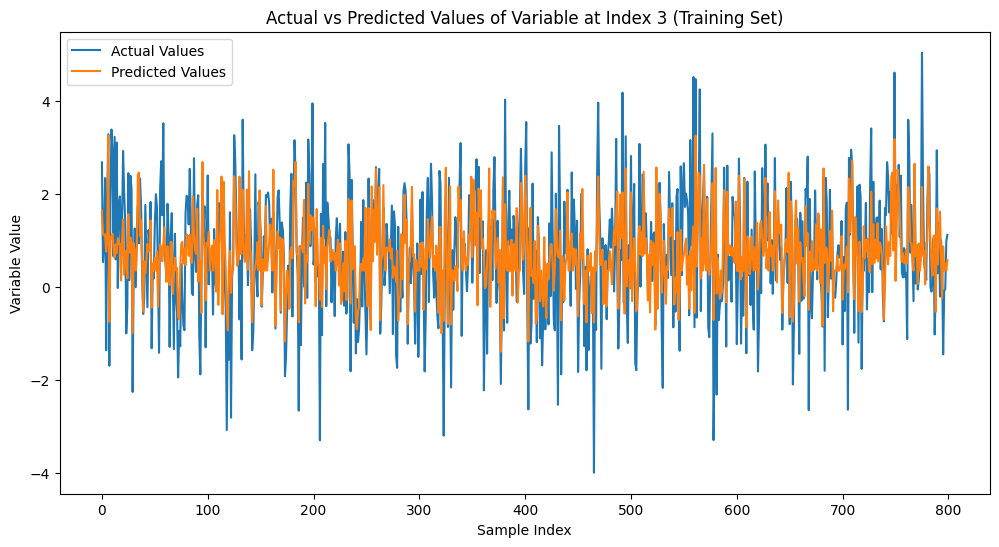

In [16]:
# Forecast using the training dataset
predictions_train0 = []
actuals_train0 = []
with torch.no_grad():
    for data in train_loader:
        data = data.to(device)
        out = model(data)
        predictions_train0.append(out.cpu())
        actuals_train0.append(data.y.cpu())

# Concatenate all predictions and actual values for training data
predictions_train0 = torch.cat(predictions_train0, dim=0)
actuals_train0 = torch.cat(actuals_train0, dim=0)

# Calculate Mean Squared Error on the training set
mse_train = mean_squared_error(actuals_train0.numpy(), predictions_train0.numpy())
print(f'Training MSE: {mse_train:.4f}')

# Plot the predictions vs actual values for the training set
plt.figure(figsize=(12, 6))
plt.plot(actuals_train0.numpy(), label='Actual Values')
plt.plot(predictions_train0.numpy(), label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Variable Value')
plt.title('Actual vs Predicted Values of Variable at Index 3 (Training Set)')
plt.legend()
plt.show()

# Effect comparison

In [17]:
(actuals_train0 - actuals_train).mean()

tensor(0.7500)

In [18]:
(predictions_train0 - predictions_train).mean()

tensor(0.7477)